In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from alphatoe.interpretability import numpy
from alphatoe import plot, game, evals, interpretability
%load_ext autoreload
%autoreload 2

In [2]:
n_epochs = 1000
epochs = [x for x in range(n_epochs) if x % 10 == 0 or x == n_epochs - 1]

chkpts = [interpretability.load_model(
    f"../scripts/models/prob all 8 layer control with checkpoints-20250708-002411-epoch{x}"
) for x in epochs]

model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control with checkpoints-20250708-002411"
)

chkpts = [(x, y) for x, y in zip(epochs, chkpts)]

In [17]:
# First, let's extract the data for all epochs
def get_projection_data(model, seq_fwd, just_proj=True):
    """Extract W_Q and compute projection for a given model checkpoint"""
    pos_emb = model.pos_embed(seq_fwd, 0)[0]  # positional embedding (10, 128)
    content_emb = model.embed(seq_fwd)[0]
    W_K = model.W_K[0, 1]  # Head index 1 (128, 16)
    
    # Compute SVD
    U, S, V = np.linalg.svd(numpy(W_K))
    
    # Project positional embeddings onto first singular vector
    Q_proj = numpy(pos_emb) @ U[:, :1]
    
    # Convert to list of values
    Q_proj = Q_proj.flatten().tolist()
    
    if just_proj:
        return Q_proj
    else:
        return {
            'u1': U[:, 0],
            'posemb': numpy(pos_emb),
            'content embed': numpy(content_emb)
        }

In [18]:
# Prepare sequence
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])

# Also get projection for final model
final_proj = get_projection_data(model, seq_fwd, just_proj=False)

In [19]:
final_proj['content embed'].shape

(10, 128)

In [28]:
print(final_proj['content embed'][6] @ final_proj['u1'])
print(final_proj['posemb'][6] @ final_proj['u1'])
print((final_proj['content embed'][5] + final_proj['posemb'][6]) @ final_proj['u1'])

0.015036819
0.6248082
0.6626933


In [55]:
embeddings = final_proj['content embed']

In [56]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

n_embeddings = len(embeddings)
similarity_matrix = np.zeros((n_embeddings, n_embeddings))

for i in range(n_embeddings):
    for j in range(n_embeddings):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

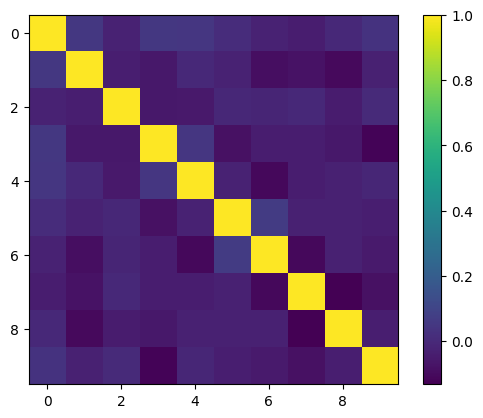

In [58]:
plt.imshow(similarity_matrix)
plt.colorbar()

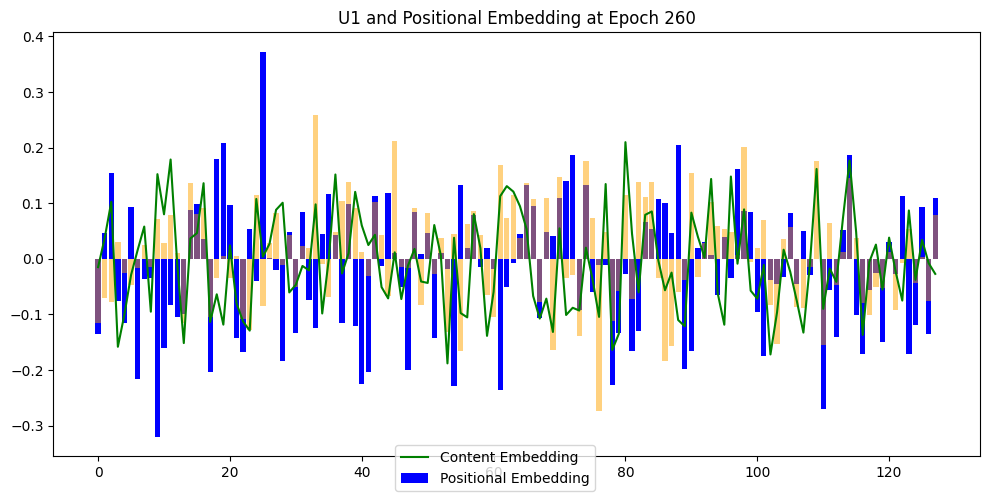

In [45]:
#bar plot U[:, :1]
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.bar(range(128), final_proj['content embed'][6], color='blue')
#add bar plot for pos_emb
axes.bar(range(128), final_proj['posemb'][6], color='orange', alpha=0.5)

axes.plot(range(128), final_proj['u1'], color='green')
#title
axes.set_title('U1 and Positional Embedding at Epoch 260')
#legend
fig.legend(['Content Embedding', 'Positional Embedding'], loc='lower center')

#tight
plt.tight_layout()